In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import torch
from data_loader import SentinelDataset
import transforms as tf
import preprocessing as pp
import torch.nn as nn
import rasterio
from torchgeo.transforms import indices

In [2]:


transforms = nn.Sequential(
    indices.AppendNDVI(index_nir=6, index_red=2), # NDVI, index 15
    tf.AppendRatioAB(index_a=11, index_b=12),  # VV/VH Ascending, index 16
)


In [3]:
%%time
SD = SentinelDataset(tile_file='tcmoran/TILE_LIST_BEST_MONTHS.csv', 
                     dir_tiles='data/train_features', 
                     dir_target='data/train_agbm',
                     device='cuda',
                     transform=transforms)

CPU times: user 5.79 ms, sys: 558 µs, total: 6.35 ms
Wall time: 5.91 ms


In [4]:
type(SD.transform_s1)

transforms.Sentinel1Scale

In [5]:
num_classes = 10

# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.conv_layer1 = self._conv_layer_set(3, 32)
        self.conv_layer2 = self._conv_layer_set(32, 64)
        self.fc1 = nn.Linear(2**3*64, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)        
        
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=0),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer
    

    def forward(self, x):
        # Set 1
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        
        return out

#Definition of hyperparameters
n_iters = 4500
num_epochs = n_iters / (len(train_x) / batch_size)
num_epochs = int(num_epochs)

# Create CNN
model = CNNModel()
#model.cuda()
print(model)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

NameError: name 'train_x' is not defined

In [6]:
def plot_by_tile_index(dataset, tile_idx, plot_channels, channel_map):
    sample = dataset[tile_idx]
    chipid, month_id = dataset.df_tile_list.iloc[tile_idx].values
    tile_name = f'Chip {chipid} {month_id}'
    
    pp.plot_bands(tile=sample['image'].detach().cpu(),
               target=sample['label'].detach().cpu(),
               tile_name=tile_name,
               plot_channels=plot_channels,
               channel_map=channel_map
              )


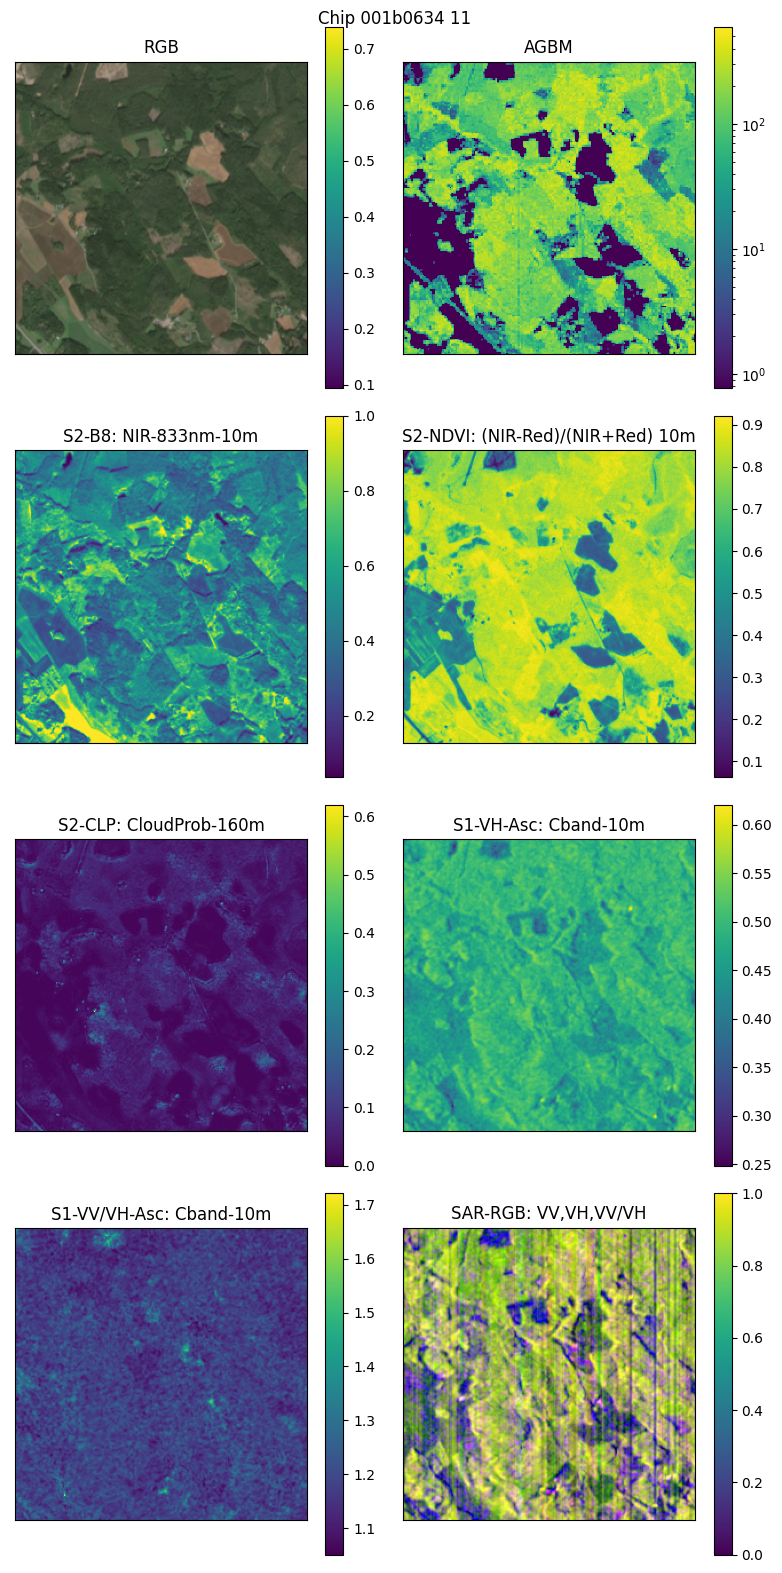

In [7]:

channel_map = {
    0: 'S2-B2: Blue-10m',
    1: 'S2-B3: Green-10m',
    2: 'S2-B4: Red-10m',
    3: 'S2-B5: VegRed-704nm-20m',
    4: 'S2-B6: VegRed-740nm-20m',
    5: 'S2-B7: VegRed-780nm-20m',
    6: 'S2-B8: NIR-833nm-10m',
    7: 'S2-B8A: NarrowNIR-864nm-20m',
    8: 'S2-B11: SWIR-1610nm-20m',
    9: 'S2-B12: SWIR-2200nm-20m',
    10: 'S2-CLP: CloudProb-160m',
    11: 'S1-VV-Asc: Cband-10m',
    12: 'S1-VH-Asc: Cband-10m',
    13: 'S1-VV-Desc: Cband-10m',
    14: 'S1-VH-Desc: Cband-10m',
    15: 'S2-NDVI: (NIR-Red)/(NIR+Red) 10m',
    16: 'S1-VV/VH-Asc: Cband-10m'
}
month_map = {
    0: 'September', 1: 'October', 2: 'November', 3: 'December',
    4: 'January', 5: 'February', 6: 'March', 7: 'April',
    8: 'May', 9: 'June', 10: 'July', 11: 'August'
}



plot_channels = {
    0: {'s2_rgb_idxs': [2, 1, 0], 'title': 'RGB'}, # RGB image, special case 
    1: {'data': 'target', 'title': 'AGBM', 'LogNorm': True}, # AGBM target data, special case 
    2: {'channel_idx': 6},  # general case of visualizing by channel_index 
    3: {'channel_idx': 15},
    4: {'channel_idx': 10},
    5: {'channel_idx': 12}, 
    6: {'channel_idx': 16},
    7: {'s1_rgb_idxs': [11, 12, 16], 'title': 'SAR-RGB: VV,VH,VV/VH'}, # SAR psuedo-RGB, special case 
}




tile_idx = 4 
plot_by_tile_index(SD, tile_idx, plot_channels, channel_map)



     

     


In [9]:
SD.__getitem__(1)

{'image': tensor([[[0.1698, 0.1653, 0.1635,  ..., 0.2385, 0.2318, 0.2353],
          [0.2073, 0.1770, 0.1720,  ..., 0.2488, 0.2458, 0.2520],
          [0.2748, 0.2015, 0.1880,  ..., 0.2423, 0.2418, 0.2320],
          ...,
          [0.2450, 0.1745, 0.1533,  ..., 0.1770, 0.1733, 0.1770],
          [0.2828, 0.2020, 0.1105,  ..., 0.1758, 0.1725, 0.1820],
          [0.2745, 0.2238, 0.1213,  ..., 0.1755, 0.1735, 0.1793]],
 
         [[0.2240, 0.2285, 0.2263,  ..., 0.2810, 0.2800, 0.2743],
          [0.2870, 0.2435, 0.2350,  ..., 0.2995, 0.2940, 0.3028],
          [0.3533, 0.2613, 0.2423,  ..., 0.3075, 0.3028, 0.3048],
          ...,
          [0.2825, 0.2433, 0.1948,  ..., 0.2368, 0.2415, 0.2438],
          [0.2588, 0.2083, 0.1600,  ..., 0.2285, 0.2408, 0.2512],
          [0.3168, 0.2903, 0.1470,  ..., 0.2280, 0.2330, 0.2370]],
 
         [[0.2898, 0.2855, 0.2973,  ..., 0.3338, 0.3515, 0.3358],
          [0.3655, 0.3025, 0.2975,  ..., 0.3640, 0.3608, 0.3883],
          [0.4698, 0.3233, 0.31

In [ ]:
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(train_x,train_y)
test = torch.utils.data.TensorDataset(test_x,test_y)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)